In [25]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = "cyber_threat_twitter_mock_1000.csv"  # Replace with the correct path
df = pd.read_csv(file_path)

# Display basic info
print("\nClass Distribution:")
print(df['label'].value_counts())



Class Distribution:
label
normal    700
threat    300
Name: count, dtype: int64


In [26]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenization and lemmatization
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(tokens)

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

# Check preprocessed data
print(df[['text', 'clean_text']].head())


                                                text  \
0  MITRE ATT&CK reports new TTP for lateral movem...   
1  ⚠️ New malware exploiting CVE-2024-1234. Updat...   
2  ⚠️ New malware exploiting CVE-2024-1234. Updat...   
3  📚 Reading a new book on productivity. Highly r...   
4  🌞 Beautiful day at the beach! #Vacation #Beach...   

                                          clean_text  
0  mitre attck report new ttp lateral movement vi...  
1           new malware exploiting cve update system  
2           new malware exploiting cve update system  
3     reading new book productivity highly recommend  
4                                beautiful day beach  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['clean_text']).toarray()

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['label'])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nShape of training data:", X_train.shape)
print("Shape of testing data:", X_test.shape)



Shape of training data: (800, 235)
Shape of testing data: (200, 235)



Multi-Class Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00        57

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



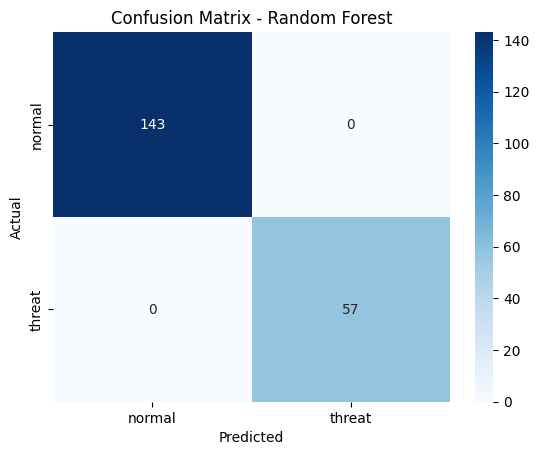

In [28]:
# Multi-Class Classification using Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("\nMulti-Class Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



One-Class Classification Report:
              precision    recall  f1-score   support

          -1       0.83      1.00      0.90       700
           1       1.00      0.51      0.67       300

    accuracy                           0.85      1000
   macro avg       0.91      0.75      0.79      1000
weighted avg       0.88      0.85      0.83      1000

AUC-ROC Score: 0.7533


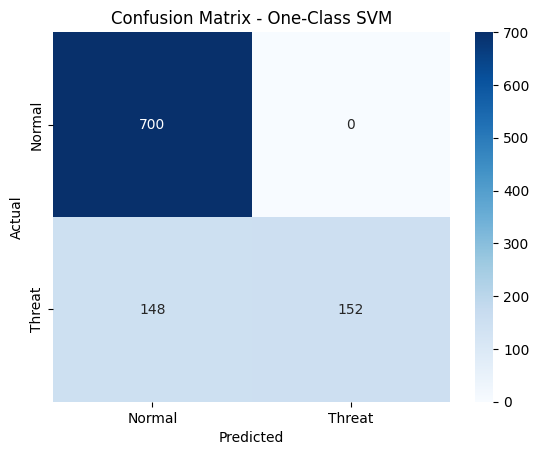

In [29]:
# Filter threat class for one-class classifier training
threat_df = df[df['label'] == 'threat']
X_threat = vectorizer.transform(threat_df['clean_text']).toarray()

# One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
ocsvm.fit(X_threat)

# Testing on the entire dataset
y_test_oc = np.where(df['label'] == 'threat', 1, -1)  # 1 = threat, -1 = normal
X_all = vectorizer.transform(df['clean_text']).toarray()

# Predictions
y_pred_oc = ocsvm.predict(X_all)

# Evaluation
print("\nOne-Class Classification Report:")
print(classification_report(y_test_oc, y_pred_oc))

# AUC-ROC Score
auc = roc_auc_score(y_test_oc, y_pred_oc)
print(f"AUC-ROC Score: {auc:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test_oc, y_pred_oc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Threat'], yticklabels=['Normal', 'Threat'])
plt.title("Confusion Matrix - One-Class SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Binary Classification Model
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize Model
input_dim = 790
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier(input_dim)
model_save_path = "./cyber_threat_one_class_classifier.pth"
# Recreate the model architecture
model = BinaryClassifier(input_dim=input_dim)  # Same architecture as before
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)
model.eval()

print("✅ Model Initialized!")


✅ Model Initialized!


In [31]:
import torch
import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to perform inference on new tweets
def predict_tweet(model, vectorizer, tweet_text, device):
    model.eval()

    # Vectorize the input tweet using the same TF-IDF vectorizer
    tweet_vector = vectorizer.transform([tweet_text]).toarray()
    tweet_tensor = torch.tensor(tweet_vector, dtype=torch.float32).to(device)

    # Perform inference
    with torch.no_grad():
        output = model(tweet_tensor).squeeze().item()

    # Interpret the result
    label = "Threat" if output >= 0.5 else "Normal"
    confidence = output if output >= 0.5 else 1 - output

    return label, confidence

# Example Usage
tweets = [
    "Over scientist prevent bill business. bitcoin Director give heart wall.",
    "Hold I discuss fast. distributed denial Through detail table budget boy ball.,",
    "Malware detected in system logs. Immediate action required!",
    "Just watched an amazing movie! Highly recommend it!"
]
# Load the saved vectorizer
vectorizer_save_path = './tfidf_vectorizer_one_class_classifier.pkl'
vectorizer = joblib.load(vectorizer_save_path)

print("✅ TF-IDF Vectorizer loaded successfully!")
# Run inference on multiple tweets
print("\n✅ **Real-Time Inference Results:**")
for tweet in tweets:
    label, confidence = predict_tweet(model, vectorizer, tweet, device)
    print(f"Tweet: {tweet}")
    print(f"Prediction: {label} (Confidence: {confidence:.4f})\n")


✅ TF-IDF Vectorizer loaded successfully!

✅ **Real-Time Inference Results:**
Tweet: Over scientist prevent bill business. bitcoin Director give heart wall.
Prediction: Threat (Confidence: 0.9996)

Tweet: Hold I discuss fast. distributed denial Through detail table budget boy ball.,
Prediction: Threat (Confidence: 0.9999)

Tweet: Malware detected in system logs. Immediate action required!
Prediction: Threat (Confidence: 0.9999)

Tweet: Just watched an amazing movie! Highly recommend it!
Prediction: Normal (Confidence: 0.9997)

